`imdb_reviews` dataset is a large movie review dataset. This dataset is for binary sentiment classification containing a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. All the reviews have either a *positive* or *negative* sentiment.
Reference: http://ai.stanford.edu/~amaas/data/sentiment/

# Install and load libraries

In [ ]:
# Download tensorflow datasets
!pip install tensorflow_datasets

# A dependency of the preprocessing for BERT inputs
!pip install tensorflow_text
!pip install tensorflow_hub

In [ ]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
import tensorflow_text as text

# Load the dataset


In [ ]:
# Load and split the data into training, validation and test data
train_dataset, val_dataset, test_dataset = tfds.load(name="imdb_reviews", split=('train[:80%]', 'train[80%:]', 'test'), as_supervised=True)

print("Training set: ", len(train_dataset), "samples")
print("Validation set: ", len(val_dataset), "samples")
print("Test set: ", len(test_dataset), "samples")

Training set:  20000 samples
Validation set:  5000 samples
Test set:  25000 samples


In [ ]:
### Convert Tensorflow Dataset to numpy arrays of feature vector X and label y

# Convert training set
train_ds_numpy = tfds.as_numpy(train_dataset) # Convert TF Dataset to an iterable of numpy array
train_numpy = np.vstack(list(train_ds_numpy)) # Stack to full numpy array
X_train = np.array(list(map(lambda x: x[0], train_numpy))) # Extract review (index 0) from numpy vector
y_train = np.array(list(map(lambda x: x[1], train_numpy))).astype(np.int16) # Extract label (index 1) from numpy vector and convert grom string to number
print("X_train shape: " + str(X_train.shape))
print("y_train shape: " + str(y_train.shape))

# Convert validation set
val_ds_numpy = tfds.as_numpy(val_dataset) # Convert TF Dataset to an iterable of numpy array
val_numpy = np.vstack(list(val_ds_numpy)) # Stack to full numpy array
X_val = np.array(list(map(lambda x: x[0], val_numpy))) # Extract review (index 0) from numpy vector
y_val = np.array(list(map(lambda x: x[1], val_numpy))).astype(np.int16) # Extract label (index 1) from numpy vector
print("X_val shape: " + str(X_val.shape))
print("y_val shape: " + str(y_val.shape))

# Convert test set
test_ds_numpy = tfds.as_numpy(test_dataset) # Convert TF Dataset to an iterable of numpy array
test_numpy = np.vstack(list(test_ds_numpy)) # Stack to full numpy array
X_test = np.array(list(map(lambda x: x[0], test_numpy))) # Extract review (index 0) from numpy vector
y_test = np.array(list(map(lambda x: x[1], test_numpy))).astype(np.int16) # Extract label (index 1) from numpy vector
print("X_test shape: " + str(X_test.shape))
print("y_test shape: " + str(y_test.shape))

X_train shape: (20000,)
y_train shape: (20000,)
X_val shape: (5000,)
y_val shape: (5000,)
X_test shape: (25000,)
y_test shape: (25000,)


In [ ]:
# Mapping from name to URL of Bert models
map_name_to_model = {
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
}

# Mapping from name to URL of respective processings for the Bert models
map_name_to_preprocess = {
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

bert_name = 'small_bert/bert_en_uncased_L-4_H-128_A-2'

# Get URLs of model and processing from tfhub
tfhub_model = map_name_to_model[bert_name]
tfhub_preprocess = map_name_to_preprocess[bert_name]

print('BERT model selected           : ' + str(tfhub_model))
print('Preprocess model auto-selected: ' + str(tfhub_preprocess))

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [ ]:
# Load the BERT model and preprocessing from TensorFlow Hub
bert_model = hub.KerasLayer(tfhub_model,trainable=True, name='BERT_encoder')
bert_preprocess = hub.KerasLayer(tfhub_preprocess, name = 'preprocessing')

# Function to get embedding feature vectors of each encoder block
def get_encoder_block_embeddings(text):
    # Preprocess the text using BERT preprocessing
    preprocessed_text = bert_preprocess(text)
    # Get the BERT model outputs
    bert_outputs = bert_model(preprocessed_text)
    # Extract the hidden_states which contains embeddings from all encoder blocks
    hidden_states = bert_outputs['encoder_outputs']
    # Return the embeddings from each encoder block as a list of tensors
    return hidden_states[-1]

text_example = ['It is a cool movie. The graphics and the animation are awesome.',
                'The movie was really bad. I would not recommend it to anyone.']

encoder_block_embeddings = get_encoder_block_embeddings(text_example)
encoder_block_embeddings

<tf.Tensor: shape=(2, 128, 128), dtype=float32, numpy=
array([[[ 0.73784965,  0.6468414 ,  1.4904901 , ...,  0.7170412 ,
          0.39639616,  2.4403534 ],
        [ 0.82598066,  2.278494  ,  2.7428224 , ...,  0.04711669,
         -0.20306677,  0.41707635],
        [ 1.8927286 ,  2.3991027 ,  2.530036  , ...,  1.2135599 ,
          0.5009977 , -0.42372137],
        ...,
        [ 0.9149519 ,  0.67947525,  3.0144296 , ...,  0.9499518 ,
          0.61819315,  2.6098416 ],
        [ 1.0355229 ,  0.5342034 ,  3.4464831 , ...,  0.8159932 ,
          0.0781073 ,  2.3334985 ],
        [ 0.60048616, -0.1359011 ,  3.8240137 , ...,  0.7554917 ,
         -0.66331166,  1.7184199 ]],

       [[ 0.8755345 ,  1.0891194 , -0.29904932, ...,  0.3457279 ,
          0.35335958,  2.2415688 ],
        [ 1.9044834 ,  1.2882807 ,  2.7091234 , ...,  0.4765866 ,
          0.40065   ,  1.3620956 ],
        [ 2.702751  ,  0.9061697 ,  1.332027  , ..., -0.4199657 ,
         -0.3847281 ,  2.6498637 ],
        ...,

In [ ]:
# Function to combine the embedding feature vectors from all encoder blocks
def combine_encoder_block_embeddings(embeddings):
    combined_embedding = tf.concat(embeddings, axis=-1)
    return combined_embedding

combined_embedding = combine_encoder_block_embeddings(encoder_block_embeddings)
combined_embedding

<tf.Tensor: shape=(2, 128, 128), dtype=float32, numpy=
array([[[ 0.73784965,  0.6468414 ,  1.4904901 , ...,  0.7170412 ,
          0.39639616,  2.4403534 ],
        [ 0.82598066,  2.278494  ,  2.7428224 , ...,  0.04711669,
         -0.20306677,  0.41707635],
        [ 1.8927286 ,  2.3991027 ,  2.530036  , ...,  1.2135599 ,
          0.5009977 , -0.42372137],
        ...,
        [ 0.9149519 ,  0.67947525,  3.0144296 , ...,  0.9499518 ,
          0.61819315,  2.6098416 ],
        [ 1.0355229 ,  0.5342034 ,  3.4464831 , ...,  0.8159932 ,
          0.0781073 ,  2.3334985 ],
        [ 0.60048616, -0.1359011 ,  3.8240137 , ...,  0.7554917 ,
         -0.66331166,  1.7184199 ]],

       [[ 0.8755345 ,  1.0891194 , -0.29904932, ...,  0.3457279 ,
          0.35335958,  2.2415688 ],
        [ 1.9044834 ,  1.2882807 ,  2.7091234 , ...,  0.4765866 ,
          0.40065   ,  1.3620956 ],
        [ 2.702751  ,  0.9061697 ,  1.332027  , ..., -0.4199657 ,
         -0.3847281 ,  2.6498637 ],
        ...,

In [ ]:
# Build the complete model, including preprocessing module, BERT model and classification layers
def build_model():
  text_input = keras.layers.Input(shape=(), dtype=tf.string, name='text') # Define text input layer
  preprocessing_layer = hub.KerasLayer(tfhub_preprocess, name='preprocessing') # Define preprocessing layer
  encoder_inputs = preprocessing_layer(text_input) # Get the text input through the preprocessing layer. Output of this is input of Bert model (a.k.a. encoder)
  encoder = hub.KerasLayer(tfhub_model, trainable=True, name='BERT_encoder') # Define Bert model. 'Trainable' = True parameter is for finetuning purpose
  outputs = encoder(encoder_inputs) # Get the encoder_inputs through the Bert model to get output embedding vector
  embeddings = outputs['encoder_outputs']
  combined = tf.concat(embeddings, axis=-1)
  pooled = tf.keras.layers.GlobalAveragePooling1D()(combined)
  net = keras.layers.Dense(64, activation='relu')(pooled) # Add dense layer
  net = keras.layers.BatchNormalization()(net) # Add batch norm layer
  net = keras.layers.Dropout(0.5)(net) # Add dropout layer
  net = keras.layers.Dense(1, activation='sigmoid', name='classifier')(net) # Add binary classification output layer
  return keras.Model(inputs=text_input, outputs=net, name="BERT_complete_model")

# Build the complete model
model = build_model()

# Print the model architecture
model.summary()

Model: "BERT_complete_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 preprocessing (KerasLayer)  {'input_word_ids': (None,    0         ['text[0][0]']                
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             , 'input_type_ids': (None,                                           
                              128)}                                                               
                                                                                

In [ ]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate = 0.01),
                         loss='binary_crossentropy',
                         metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train,
                               epochs=10,
                               batch_size = 64,
                               validation_data=(X_val, y_val),
                              )

Epoch 1/10
313/313 [==============================] - 109s 327ms/step - loss: 0.4123 - accuracy: 0.8141 - val_loss: 0.4240 - val_accuracy: 0.8038
Epoch 2/10
313/313 [==============================] - 97s 309ms/step - loss: 0.4034 - accuracy: 0.8189 - val_loss: 0.4158 - val_accuracy: 0.8090
Epoch 3/10
313/313 [==============================] - 97s 311ms/step - loss: 0.3924 - accuracy: 0.8225 - val_loss: 0.5134 - val_accuracy: 0.7704
Epoch 4/10
313/313 [==============================] - 96s 307ms/step - loss: 0.3813 - accuracy: 0.8310 - val_loss: 0.4343 - val_accuracy: 0.8060
Epoch 5/10
313/313 [==============================] - 100s 320ms/step - loss: 0.3676 - accuracy: 0.8361 - val_loss: 1.1418 - val_accuracy: 0.6076
Epoch 6/10
313/313 [==============================] - 95s 304ms/step - loss: 0.3560 - accuracy: 0.8439 - val_loss: 0.4094 - val_accuracy: 0.8080
Epoch 7/10
313/313 [==============================] - 96s 306ms/step - loss: 0.3457 - accuracy: 0.8523 - val_loss: 0.4415 - val_

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

782/782 [==============================] - 63s 81ms/step - loss: 0.4306 - accuracy: 0.8139
Test Loss: 0.4305551052093506
Test Accuracy: 0.8138800263404846


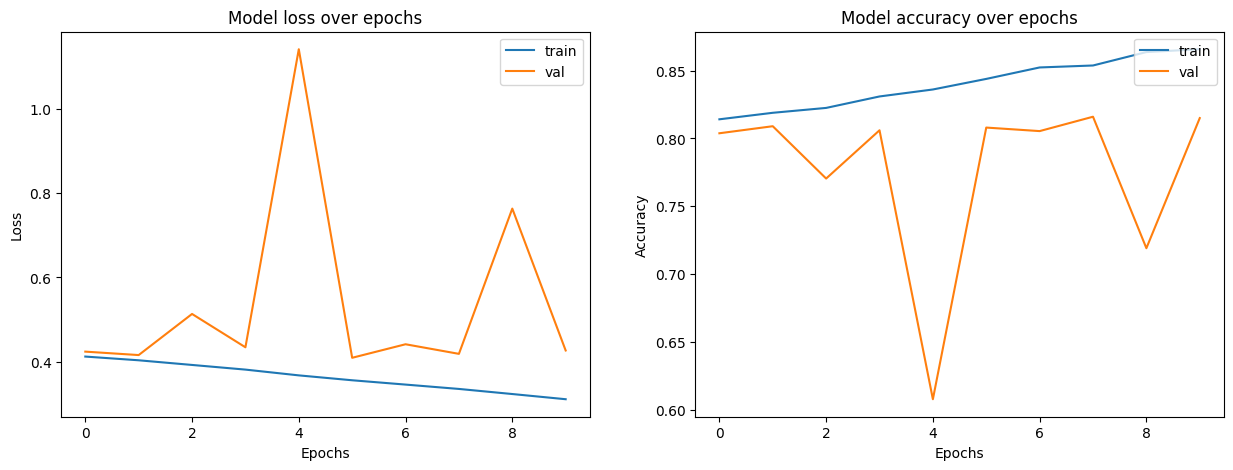

In [ ]:
# Initialize the plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot model loss during training
ax1.plot(history.history["loss"])
ax1.plot(history.history["val_loss"])
ax1.legend(["train", "val"], loc="upper right")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_title("Model loss over epochs")

# Plot model accuracy during training
ax2.plot(history.history["accuracy"])
ax2.plot(history.history["val_accuracy"])
ax2.legend(["train", "val"], loc="upper right")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
ax2.set_title("Model accuracy over epochs")
plt.show()

In [ ]:
# Make prediction on new text reviews
sample_reviews = [('It is a cool movie. The graphics and the animation are awesome'),
                  ('The movie was really bad. I would not recommend it to anyone.')]
predictions = model.predict(np.array(sample_reviews))
print(predictions[0])
print(predictions[1])

1/1 [==============================] - 0s 32ms/step
[0.99906236]
[0.00230189]
